In [1]:
import os
from google.colab import files
files.upload()
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d arjuntejaswi/plant-village
!unzip plant-village.zip -d ./data


Streaming output truncated to the last 5000 lines.
  inflating: ./data/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: ./data/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: ./data/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: ./data/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: ./data/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: ./data/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: ./data/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0922e026-b563-438d-b9ed-7476153023ce___YLCV_GCREC 2258.JPG  
  infla

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

## Using tf.keras.preprocessing.image_dataset_from_directory to import data from the potato directory

In [3]:
import tensorflow as tf

dataset = tf.keras.preprocessing.image_dataset_from_directory(
   './data/PlantVillage',  # Corrected path
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(256, 256),
    batch_size=32,
    class_names=[
        'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy'
    ]
)

Found 2152 files belonging to 3 classes.
Using 1722 files for training.


In [4]:
len(dataset)

54

In [5]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)
  ds_len = len(ds)
  train_ds = ds.take(int(train_split*ds_len))
  val_ds = ds.skip(int(train_split*ds_len)).take(int(val_split*ds_len))
  test_ds = ds.skip(int(train_split*ds_len)+int(val_split*ds_len))
  return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

43
5
6


In [8]:

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [9]:
for img,label in train_ds.take(1):
  print(img)
  print(label.numpy())

tf.Tensor(
[[[[151. 137. 136.]
   [150. 136. 135.]
   [141. 127. 126.]
   ...
   [191. 181. 179.]
   [190. 180. 178.]
   [181. 171. 169.]]

  [[119. 105. 104.]
   [156. 142. 141.]
   [157. 143. 142.]
   ...
   [190. 180. 178.]
   [190. 180. 178.]
   [181. 171. 169.]]

  [[143. 129. 128.]
   [123. 109. 108.]
   [133. 119. 118.]
   ...
   [191. 181. 179.]
   [190. 180. 178.]
   [184. 174. 172.]]

  ...

  [[144. 132. 136.]
   [107.  95.  99.]
   [131. 119. 123.]
   ...
   [154. 145. 150.]
   [156. 147. 152.]
   [156. 147. 152.]]

  [[121. 109. 113.]
   [128. 116. 120.]
   [114. 102. 106.]
   ...
   [162. 153. 158.]
   [164. 155. 160.]
   [163. 154. 159.]]

  [[140. 128. 132.]
   [117. 105. 109.]
   [114. 102. 106.]
   ...
   [163. 154. 159.]
   [164. 155. 160.]
   [161. 152. 157.]]]


 [[[126. 120. 130.]
   [121. 115. 125.]
   [116. 110. 120.]
   ...
   [119. 111. 126.]
   [125. 117. 132.]
   [129. 121. 136.]]

  [[112. 106. 116.]
   [109. 103. 113.]
   [106. 100. 110.]
   ...
   [117. 1

In [10]:
resize_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(256,256),
    tf.keras.layers.Rescaling(1.0/255)
])

In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

In [12]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential

In [13]:
model = Sequential()
# model.add(resize_rescale)
# model.add(data_augmentation)
# Define input_shape in the first Conv2D layer
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer = "adam",loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

history = model.fit(train_ds, epochs=30, batch_size=32,verbose = 1, validation_data=val_ds)

Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - accuracy: 0.4523 - loss: 2.1860 - val_accuracy: 0.4437 - val_loss: 1.0051
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5962 - loss: 0.8397 - val_accuracy: 0.7312 - val_loss: 0.5522
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8000 - loss: 0.4455 - val_accuracy: 0.8125 - val_loss: 0.4855
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8050 - loss: 0.4617 - val_accuracy: 0.9000 - val_loss: 0.2103
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9056 - loss: 0.2396 - val_accuracy: 0.9438 - val_loss: 0.1642
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9199 - loss: 0.1973 - val_accuracy: 0.9438 - val_loss: 0.1511
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9235 - loss: 0.2113 - val_accuracy: 0.9375 - val_loss: 0.1675
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9427 - loss: 0.1369 - val_accuracy: 0.9625 -

In [16]:
# Evaluate model
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9837 - loss: 0.1104
Validation Loss: 0.09425409883260727
Validation Accuracy: 0.987500011920929


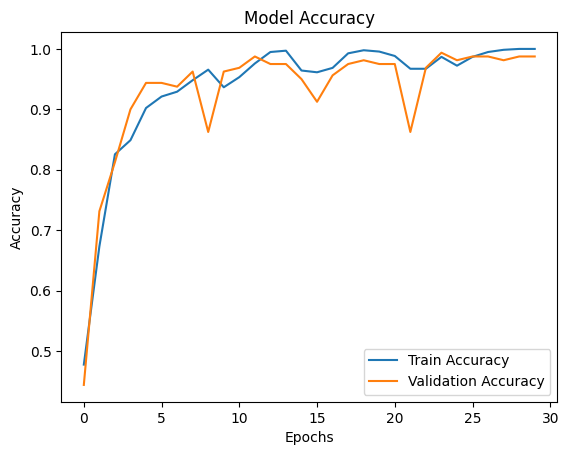

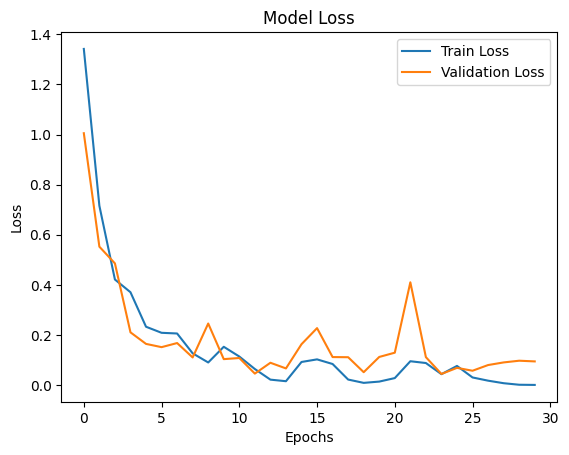

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


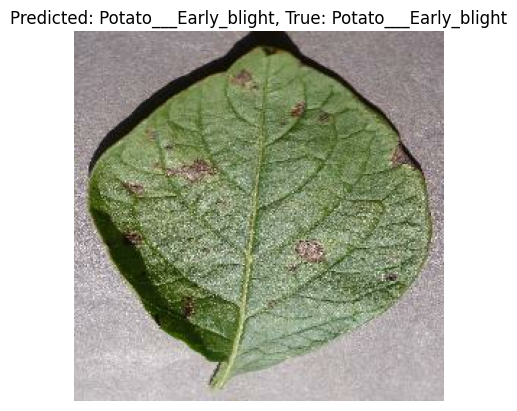

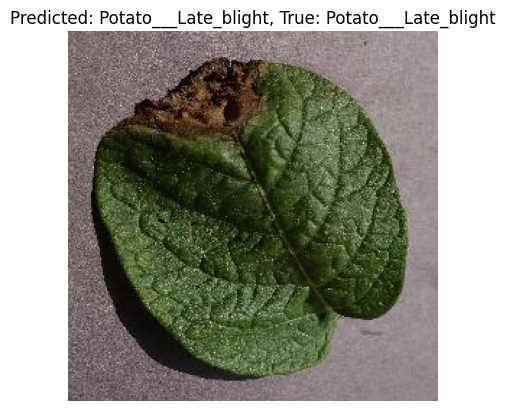

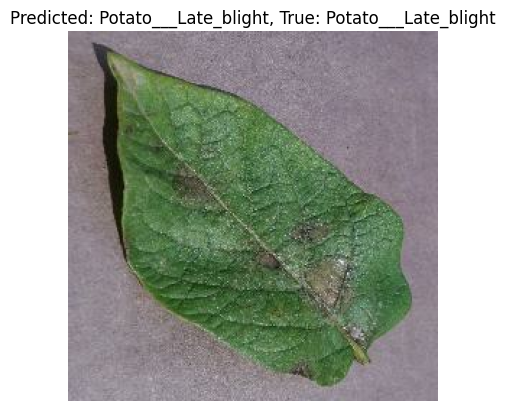

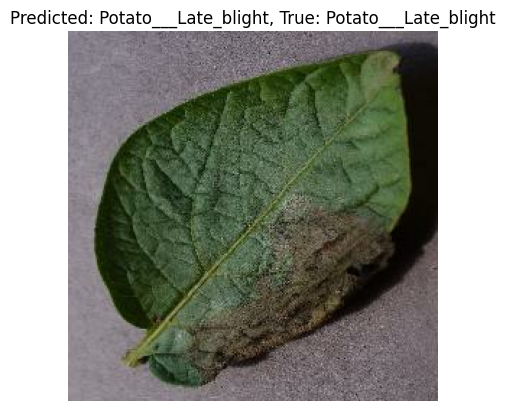

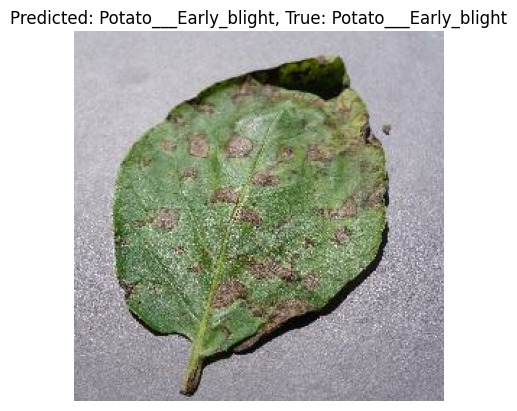

In [22]:
import numpy as np
for images, labels in val_ds.take(1):  # Take one batch for prediction demonstration
    predictions = model.predict(images)
    for i in range(5):  # Display predictions for first 5 images in the batch
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Predicted: {class_name[np.argmax(predictions[i])]}, True: {class_name[labels[i]]}")
        plt.axis("off")
        plt.show()

In [23]:
model.save('model.h5')
